# A/B Testing in Digital Marketing
Marketing companies often use A/B testing to evaluate the effectiveness of different campaign strategies. This involves showing different versions of a variable (e.g., a web page or banner) to different segments of an audience simultaneously to determine which version has the greatest impact.

In our A/B test, most participants see ads (experimental group), while a smaller segment sees a Public Service Announcement (PSA) or nothing (control group). Our analysis aims to answer two key questions:

- Will the campaign be successful?
- How much of the success can be attributed to the ads?

Using this dataset, we will analyze group performance, assess ad effectiveness, and determine if the differences between the groups are statistically significant. In this guide, we will explore how to perform exploratory data analysis (EDA) and hypothesis testing on A/B test data using Python.

## Exploratory Data Analysis (EDA)
EDA is vital for uncovering patterns and relationships in data. We will utilize Python libraries such as Pandas, Seaborn, and Matplotlib to visualize and analyze our dataset.

### Step 1: Importing Required Libraries
First, we import the necessary libraries for data manipulation, visualization, and statistical testing.

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms
from scipy.stats import (
    ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
)
from statsmodels.stats.proportion import proportions_ztest
import warnings

# Ignore warnings for clearer output
warnings.filterwarnings("ignore")

### Step 2: Loading the Data
We then load our A/B test data into a pandas DataFrame for analysis.

In [82]:
df = pd.read_csv(r"/content/drive/MyDrive/Data Analytics Projects/A B testing in digital marketing/marketing_AB.csv")

In [83]:
df.head(5)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [84]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

### Step 3: Data Preprocessing
#### Converting Boolean Column to Integer
We convert the converted column, which is boolean, to an integer format for easier analysis.

In [85]:
df['converted_int'] = df['converted'].astype(int)

This conversion allows for more straightforward numerical operations and statistical analysis.

#### Removing Outliers
Outliers can skew results, so we remove them using the Interquartile Range (IQR) method.

In [86]:
def remove_outliers(df, column):
    """
    Removes outliers from a specified column in the dataframe using the IQR method.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    column (str): The column name from which to remove outliers.

    Returns:
    pd.DataFrame: The dataframe with outliers removed.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'total ads')

Removing outliers ensures our analysis focuses on typical behavior, making results more reliable.

### Step 4: Data Visualization
Visualizations help us understand data distributions and relationships.

#### Total Ads Viewed vs. Purchase Status by Test Group
We create bar plots to examine the relationship between ads viewed, purchase status, and test groups.

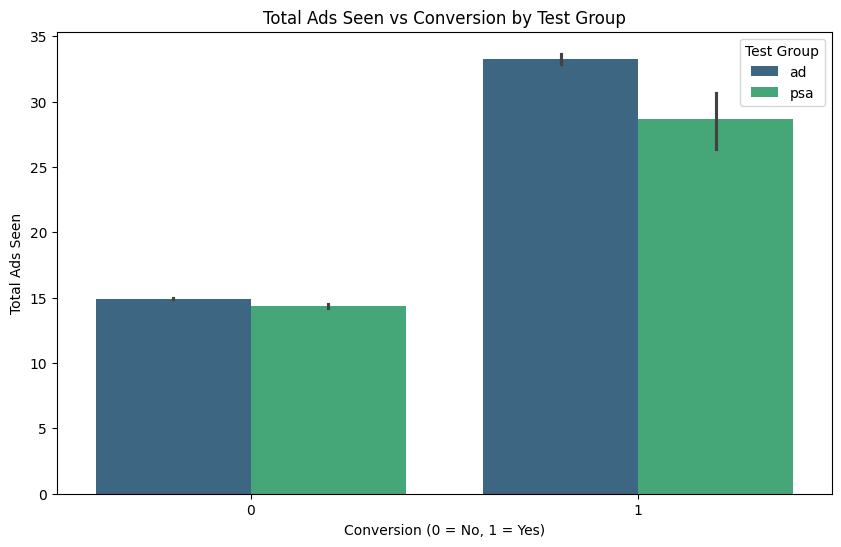

In [87]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='converted_int', y='total ads', hue='test group', palette='viridis')
plt.title('Total Ads Seen vs Conversion by Test Group')
plt.xlabel('Conversion (0 = No, 1 = Yes)')
plt.ylabel('Total Ads Seen')
plt.legend(title='Test Group')
plt.show()

The plot depicts a bar plot illustrating the likelihood of users making a purchase after encountering either an advertisement (ad) or a public service announcement (PSA). The plot reveals a notably higher purchase probability among users exposed to ads compared to those who viewed PSAs. This observation implies that advertisements exert a more substantial influence on purchasing decisions than PSAs.

#### Grouped Data Analysis
We aggregate the data by test group and the day with the most ads to calculate the mean total ads and the sum of conversions.

In [88]:
grouped_df = df.groupby(["test group", "most ads day"]).agg({"total ads": "mean", "converted_int": "sum"}).reset_index()
grouped_df.head()

,test group,most ads day,total ads,converted_int
0,ad,Friday,15.255024,958
1,ad,Monday,14.825415,1324
2,ad,Saturday,15.944834,777
3,ad,Sunday,15.679764,987
4,ad,Thursday,14.510822,835


Aggregating the data allows us to summarize and identify trends and patterns more easily.

#### Scatter Plot: Purchase Status, Total Ads Viewed, and Most Ads Day by Test Group
We use scatter plots to explore the relationship between purchase status, total ads viewed, and the day most ads were seen, grouped by test group.

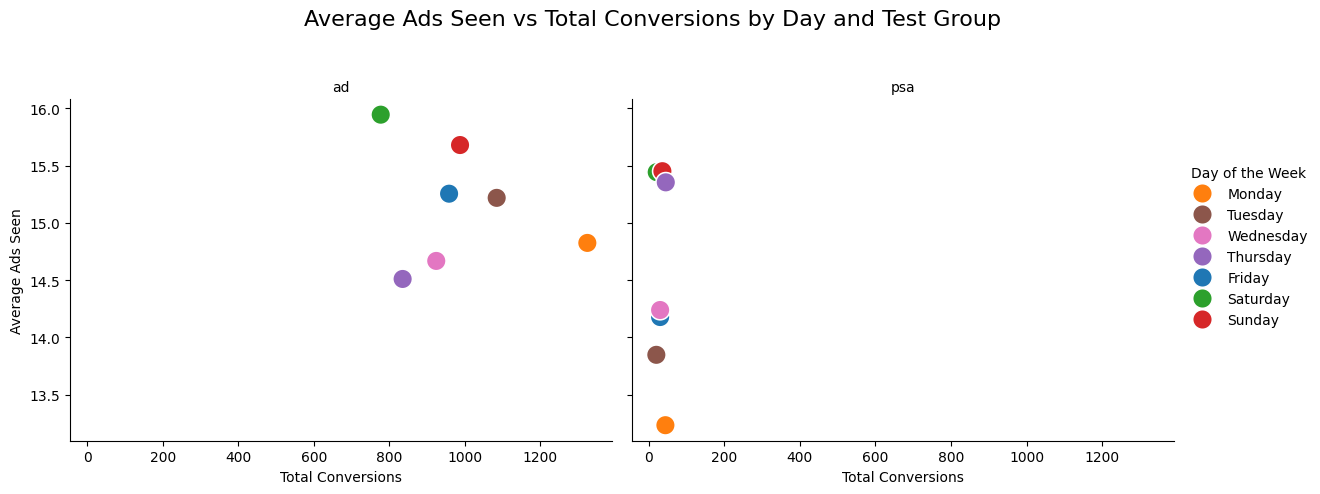

In [89]:
# Define order of days for legend
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Scatter Plot
g = sns.FacetGrid(grouped_df, col="test group", height=5, aspect=1.2)
g.map(sns.scatterplot, 'converted_int', 'total ads', 'most ads day', palette='tab10', s=200)
g.add_legend(title='Day of the Week', label_order=days_order)
g.set_axis_labels('Total Conversions', 'Average Ads Seen')
g.set_titles('{col_name}')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Average Ads Seen vs Total Conversions by Day and Test Group', fontsize=16)
plt.show()

The plot above showcases a scatter plot illustrating the correlation between the number of ads viewed by a user and the likelihood of them making a purchase, categorized by the test group (ad or PSA). The plot indicates that, across both test groups, there is a positive association between the number of ads viewed and the probability of purchasing the product.


#### KDE Plots
We create Kernel Density Estimation (KDE) plots to visualize the distribution of total ads viewed by the most ads day and test group.

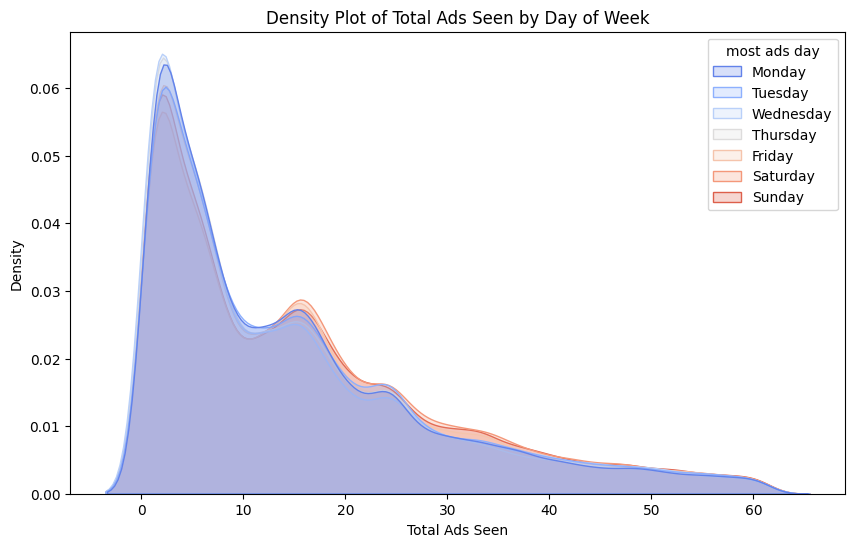

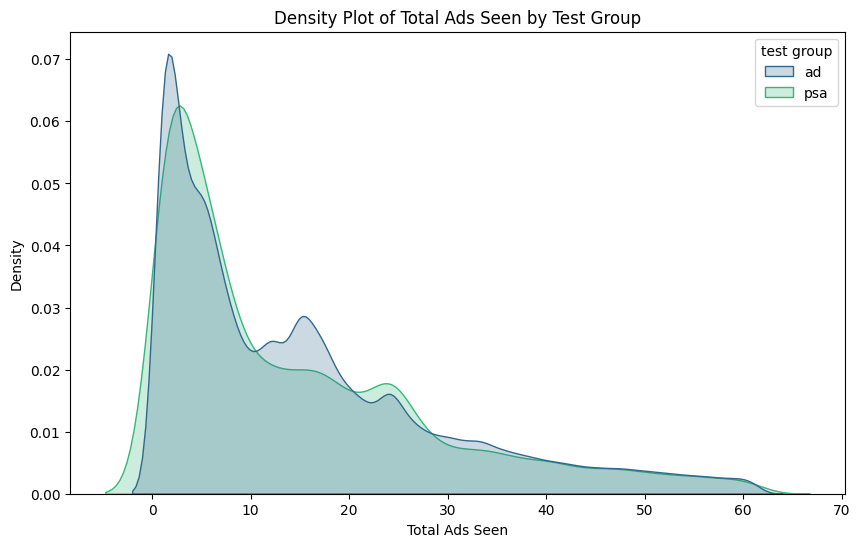

In [90]:
# KDE Plot by Most Ads Day
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='total ads', hue='most ads day', hue_order=days_order,
            fill=True, common_norm=False, palette='coolwarm')
plt.title('Density Plot of Total Ads Seen by Day of Week')
plt.xlabel('Total Ads Seen')
plt.ylabel('Density')
plt.show()

# Plot by Test Group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='total ads', hue='test group', fill=True, common_norm=False, palette='viridis')
plt.title('Density Plot of Total Ads Seen by Test Group')
plt.xlabel('Total Ads Seen')
plt.ylabel('Density')
plt.show()

KDE plots provide a smoothed visualization of data distribution, helping to understand the spread of total ads viewed across different groups, hinting at a deliberate strategy by advertisers, possibly focusing their marketing efforts on weekends to reach a wider audience.

#### Bar Plots: Total Ads Viewed by Most Ads Day and Test Group
We use bar plots to compare the total ads viewed across different days and test groups.

In [ ]:
# Bar plot for total ads viewed by most ads day and test group with order
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='most ads day', y='total ads', hue='test group', order=days_order, palette='coolwarm')
plt.title('Total Ads Viewed by Day of Week and Test Group')
plt.xlabel('Day of the Week')
plt.ylabel('Total Ads Viewed')
plt.legend(title='Test Group', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Bar plot for total ads viewed by most ads hour and test group
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='most ads hour', y='total ads', hue='test group', palette='viridis')
plt.title('Total Ads Viewed by Hour of Day and Test Group')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Ads Viewed')
plt.legend(title='Test Group', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

These bar plots help us compare the total ads viewed across different days and hours, highlighting temporal patterns in ad viewing behavior. Notably, there are disparities in the number of "total ads" between these groups. Specifically, higher values are observed on Fridays, Saturdays, and Sundays.

## Hypothesis Testing
After exploring the data, we move to hypothesis testing to draw statistically significant conclusions about our A/B test results using Statsmodels and Scipy.

### Hypothesis Testing Function
We create a function to compare two groups based on a target variable, considering normality and homogeneity of variances. The logic follows a sequence of tests as motivated below. Firstly, it checks the normality assumption using the Shapiro-Wilk test. If the data is normally distributed for both groups (p > 0.05), it proceeds to test the homogeneity of variances using Levene's test. If variances are homogeneous (p > 0.05), it applies the parametric Independent T-Test. If normality is met but variances are not homogeneous, it performs Welch's T-Test. If normality assumption fails, or if normality is met but variances are not homogeneous, the function resorts to the non-parametric Mann-Whitney U Test.


In [ ]:
def compare_groups(df, group_col, test_value, control_value, target_col):

    # H0: M1 = M2
    # H1: M1 != M2
    # REJECT H0 if p-value < 0.05.
    # DO NOT REJECT H0 if p-value > 0.05.

    # Normality Assumption
    print("-" * 150)
    print("Assumption Check Step 1")
    print("  - Normality Assumption (Shapiro-Wilk Test)")
    test_stat_test, pvalue_test = shapiro(df[df[group_col] == test_value][target_col])
    test_stat_control, pvalue_control = shapiro(df[df[group_col] == control_value][target_col])

    if pvalue_test > 0.05 and pvalue_control > 0.05:
        print("\n       * Normality assumption is met.")
        print(f'\n       * Test Group Stat = {test_stat_test:.4f}, p-value = {pvalue_test:.4f}')
        print(f'\n       * Control Group Stat = {test_stat_control:.4f}, p-value = {pvalue_control:.4f}')
        normality_assumption = True
    else:
        print("\n       * Normality assumption is not met.")
        print(f'\n       * Test Group Stat = {test_stat_test:.4f}, p-value = {pvalue_test:.4f}')
        print(f'\n       * Control Group Stat = {test_stat_control:.4f}, p-value = {pvalue_control:.4f}')
        normality_assumption = False

    # Homogeneity of Variances
    print("-" * 150)
    print("Assumption Check Step 2")
    print("  - Homogeneity of Variances (Levene's Test)")

    test_stat, pvalue = levene(df[df[group_col] == test_value][target_col],
                               df[df[group_col] == control_value][target_col])

    if pvalue > 0.05:
        variance_assumption = True
        print("\n       * Variances are homogeneous.")
        print(f'\n       * Levene Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
    else:
        variance_assumption = False
        print("\n       * Variances are not homogeneous.")
        print(f'\n       * Levene Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')

    # Parametric Test: T-Test
    if normality_assumption and variance_assumption:
        print("-" * 150)
        print("Assumptions met, performing Independent T-Test (Parametric)")

        test_stat, pvalue = ttest_ind(df[df[group_col] == test_value][target_col],
                                      df[df[group_col] == control_value][target_col],
                                      equal_var=True)
        if pvalue > 0.05:
            print("Fail to Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        else:
            print("Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')

    elif normality_assumption and not variance_assumption:
        print("-" * 150)
        print("Normality met but variances are not homogeneous, performing Welch's T-Test")

        test_stat, pvalue = ttest_ind(df[df[group_col] == test_value][target_col],
                                      df[df[group_col] == control_value][target_col],
                                      equal_var=False)
        if pvalue > 0.05:
            print("Fail to Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        else:
            print("Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')

    # Non-Parametric Test: Mann-Whitney U Test
    else:
        print("-" * 150)
        print("Assumptions not met, performing Mann-Whitney U Test (Non-Parametric)")

        test_stat, pvalue = mannwhitneyu(df[df[group_col] == test_value][target_col],
                                         df[df[group_col] == control_value][target_col])

        if pvalue > 0.05:
            print("\n  * Fail to Reject H0")
            print(f'\n  * Mann-Whitney U Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        else:
            print("\n  * Reject H0")
            print(f'\n  * Mann-Whitney U Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')

This function evaluates the normality of data distributions with the Shapiro-Wilk test and homogeneity of variances with Levene’s test, deciding between a parametric t-test or a non-parametric Mann-Whitney U test based on the results.

## Hypotheses
We establish three hypotheses and test them using the compare_groups function.

### Hypothesis 1
**Null Hypothesis (H0):** No significant difference in the mean total ads between those who purchased (1) and those who didn’t (0).

**Alternative Hypothesis (H1):** A significant difference exists in the mean total ads between those who purchased and those who didn’t.

In [ ]:
compare_groups(df, "converted_int", 1, 0, "total ads")

**Interpretation:**
- The normality assumption was not met for both the test and control groups, as indicated by the Shapiro-Wilk test (p < 0.05).
- The homogeneity of variances assumption was not met, as indicated by Levene's test (p < 0.05).

Since the assumptions for parametric tests are not met, we resort to the Mann-Whitney U Test, a non-parametric test. The p-value is 0.0000, which is less than 0.05, leading us to reject the null hypothesis. This indicates that there is a significant difference in the mean total ads between those who purchased and those who didn’t.

### Hypothesis 2
**Null Hypothesis (H0):** No significant difference in mean total ads between those who see the most ads on weekdays versus weekends.

**Alternative Hypothesis (H1):** A significant difference exists in mean total ads between those who see the most ads on weekdays versus weekends.

In [ ]:
def add_weekday_weekend_column(df, day_column, new_column_name):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekends = ['Saturday', 'Sunday']

    # Yeni sütunu oluşturma ve her güne göre etiketleme
    df[new_column_name] = df[day_column].apply(lambda x: 'weekdays' if x in weekdays else 'weekends' if x in weekends else 'Other')

    return df


df = add_weekday_weekend_column(df, 'most ads day', 'weekdays_weekends')

compare_groups(df,"weekdays_weekends", "weekdays", "weekends", "total ads")

**Interpretation:**
- Normality Assumption: The Shapiro-Wilk test indicates that the normality assumption is not met for both the weekday and weekend groups, as their p-values are less than 0.05.
- Homogeneity of Variances: Levene's test suggests that variances are not homogeneous between the weekday and weekend groups, with a p-value less than 0.05.

Due to the violated assumptions, we apply the Mann-Whitney U Test. The obtained p-value (0.0000) is below the significance level of 0.05, leading to the rejection of the null hypothesis. This indicates a significant difference in the mean total ads between individuals who see the most ads on weekdays versus weekends.


### Hypothesis 3
**Null Hypothesis (H0):** No significant difference in mean total ads between the ad group and the PSA group.

**Alternative Hypothesis (H1):** A significant difference exists in mean total ads between the ad group and the PSA group.

In [ ]:
compare_groups(df, "test group", "ad", "psa", "total ads")

**Interpretation:**
- Normality Assumption: The Shapiro-Wilk test indicates that the normality assumption is not met for both the ad and PSA groups, as their p-values are less than 0.05.
- Homogeneity of Variances: Levene's test suggests that variances are homogeneous between the ad and PSA groups, with a p-value greater than 0.05.

Due to the violated assumptions, we perform the Mann-Whitney U Test. The obtained p-value (0.0000) is below the significance level of 0.05, leading to the rejection of the null hypothesis. This indicates a significant difference in the mean total ads between the ad group and the PSA group.


### Conclusion
In this analysis, I explored the effectiveness of advertisements versus public service announcements (PSAs). Our findings from exploratory data analysis (EDA) revealed higher purchase probabilities among users exposed to ads. Hypothesis testing further validated these differences, emphasizing the significant impact of targeted advertising on purchase behavior. By integrating EDA with robust statistical methods, we underscored the pivotal role of ads in shaping consumer decisions, providing valuable insights for optimizing future marketing strategies.

Data Source: [Kaggle Marketing A/B Testing Data](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data)